# Product Review Sentiment Analysis

## Imports and basic setup

In [1]:
import os
import re
import string
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Paths
DATA_PATH = "..\data\Reviews.csv"
MODELS_DIR = "..\models"
os.makedirs(MODELS_DIR, exist_ok=True)

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\m'
C:\Users\arjun\AppData\Local\Temp\ipykernel_11836\3668638089.py:24: SyntaxWarning: invalid escape sequence '\d'
  DATA_PATH = "..\data\Reviews.csv"
C:\Users\arjun\AppData\Local\Temp\ipykernel_11836\3668638089.py:25: SyntaxWarning: invalid escape sequence '\m'
  MODELS_DIR = "..\models"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load dataset

In [2]:
df = pd.read_csv(DATA_PATH)

# Keep only necessary columns
df = df[['Score', 'Text']].dropna()

print("Original shape:", df.shape)
df.head()

Original shape: (568454, 2)


,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


## Create binary labels (Positive / Negative) and filter

In [3]:
def label_from_score(score):
    if score in [4, 5]:
        return "positive"
    elif score in [1, 2]:
        return "negative"
    else:
        return None  # for score 3

df['sentiment'] = df['Score'].apply(label_from_score)
df = df.dropna(subset=['sentiment'])

print("After filtering neutrals (Score=3):", df.shape)
print(df['sentiment'].value_counts())

After filtering neutrals (Score=3): (525814, 3)
sentiment
positive    443777
negative     82037
Name: count, dtype: int64


## Text preprocessing utilities

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords + lemmatize
    tokens = [
        lemmatizer.lemmatize(tok) 
        for tok in tokens 
        if tok not in stop_words and len(tok) > 2
    ]
    
    return " ".join(tokens)

# Quick test
sample = df['Text'].iloc[0]
print("Original:", sample[:300])
print("\nCleaned:", clean_text(sample)[:300])

Original: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Cleaned: bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better


## Apply preprocessing

In [5]:
# (this can take a while; consider sampling during dev)

# For faster experimentation, you can uncomment the next line:
# df = df.sample(50000, random_state=42)

df['clean_text'] = df['Text'].apply(clean_text)
df = df.dropna(subset=['clean_text'])
df.head()


,Score,Text,sentiment,clean_text
0,5,I have bought several of the Vitality canned d...,positive,bought several vitality canned dog food produc...
1,1,Product arrived labeled as Jumbo Salted Peanut...,negative,product arrived labeled jumbo salted peanutsth...
2,4,This is a confection that has been around a fe...,positive,confection around century light pillowy citrus...
3,2,If you are looking for the secret ingredient i...,negative,looking secret ingredient robitussin believe f...
4,5,Great taffy at a great price. There was a wid...,positive,great taffy great price wide assortment yummy ...


## Train-test split

In [6]:
X = df['clean_text'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 420651
Test size: 105163


## TF-IDF vectorization

In [7]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),     # unigrams + bigrams
    min_df=5,               # ignore very rare words
    max_df=0.9              # ignore very common words
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

TF-IDF train shape: (420651, 50000)
TF-IDF test shape: (105163, 50000)


## Train model (Logistic Regression or Linear SVM)

In [8]:
# Option 1: Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)
log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))


# Option 2: Linear SVM
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)

y_pred_svm = svm_clf.predict(X_test_tfidf)
print("\nLinear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report (Linear SVM):\n")
print(classification_report(y_test, y_pred_svm))

Logistic Regression Accuracy: 0.9446763595561176

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

    negative       0.89      0.74      0.81     16407
    positive       0.95      0.98      0.97     88756

    accuracy                           0.94    105163
   macro avg       0.92      0.86      0.89    105163
weighted avg       0.94      0.94      0.94    105163


Linear SVM Accuracy: 0.9546038055209531

Classification Report (Linear SVM):

              precision    recall  f1-score   support

    negative       0.88      0.82      0.85     16407
    positive       0.97      0.98      0.97     88756

    accuracy                           0.95    105163
   macro avg       0.92      0.90      0.91    105163
weighted avg       0.95      0.95      0.95    105163



In [9]:
# Choose the better model based on accuracy / F1.
best_model = svm_clf

## Confusion matrix for chosen model

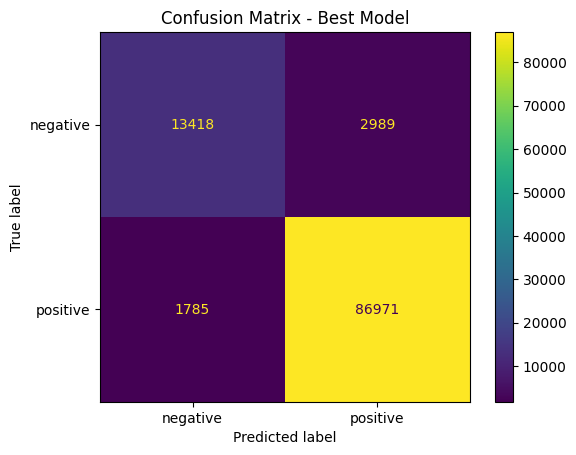

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, best_model.predict(X_test_tfidf), labels=["negative", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot()
plt.title("Confusion Matrix - Best Model")
plt.show()

## Save model and vectorizer

In [11]:
MODEL_PATH = os.path.join(MODELS_DIR, "sentiment_model.pkl")
VECTORIZER_PATH = os.path.join(MODELS_DIR, "vectorizer.pkl")

joblib.dump(best_model, MODEL_PATH)
joblib.dump(tfidf, VECTORIZER_PATH)

print(f"Saved model to: {MODEL_PATH}")
print(f"Saved vectorizer to: {VECTORIZER_PATH}")

Saved model to: ..\models\sentiment_model.pkl
Saved vectorizer to: ..\models\vectorizer.pkl


## Helper function for prediction (to mirror app behavior)

In [12]:
def predict_sentiment(texts, model=best_model, vectorizer=tfidf):
    """
    texts: list of raw review strings
    returns: list of predicted labels
    """
    cleaned = [clean_text(t) for t in texts]
    X_vec = vectorizer.transform(cleaned)
    return model.predict(X_vec)

# Quick sanity check
test_reviews = [
    "Absolutely love this product, works like a charm!",
    "Terrible quality, broke after one use. Waste of money."
]
print(predict_sentiment(test_reviews))

['positive' 'negative']
